# 6/21

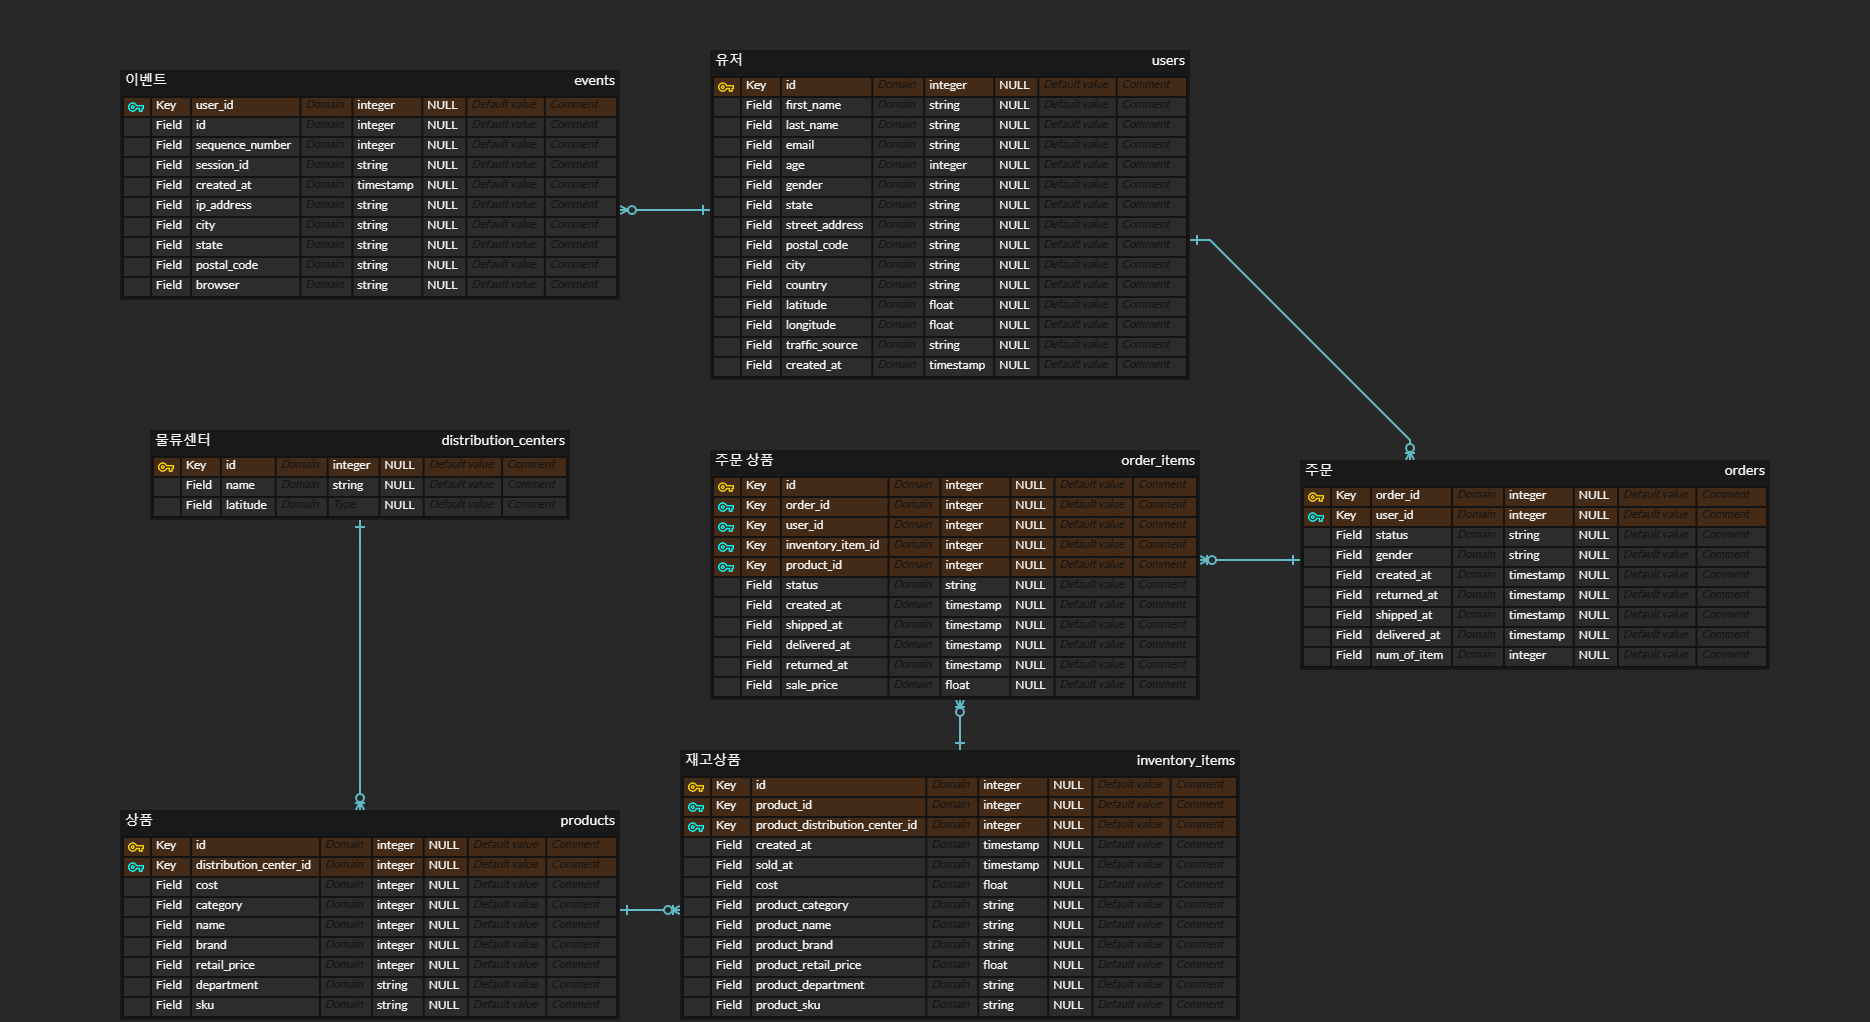

In [1]:
# 데이터 로드 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

df_order = pd.read_csv('orders.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object'})
df_item = pd.read_csv('order_items.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object'})

In [2]:
# merge 용 key 확인
# order_id가 join key로 보이는데, 실제로 order_id가 df_order에서 unique한지 확인.
print(df_order['order_id'].size)
print(df_order['order_id'].nunique())
# unique함.

124776
124776


In [3]:
# 두 집합['order_id']의 여집합이 존재하는지 확인
item_set = set(df_item['order_id'])
order_set = set(df_order['order_id'])
print(len(item_set.intersection(order_set))) # df_order['order_id'].size와 동일.
print(len(item_set.difference(order_set)))
print(len(order_set.difference(item_set)))
# 여집합 없음.
# order_id로 join하면 모든 order 포함됨.

124776
0
0


In [4]:
# df_order와 df_item merge
df_merged = pd.merge(left=df_order, right=df_item, on='order_id')
# df_merged의 중복 여부 확인
print(df_merged.size)
print(df_merged.drop_duplicates().size)
# 중복 열 없음.

3437233
3437233


In [5]:
# order['created_at']과 item['created_at']의 관계는?
# order['created_at'] > item['created_at']이 가능할까?
df_merged.loc[df_merged['created_at_x'] == df_merged['created_at_y']]
# order['created_at'] > item['created_at'] 존재.
# order['created_at'] < item['created_at'] 존재.
# 이게 무슨 의미인가?

order_id user_id_x    status_x gender             created_at_x  \
7863      71528     57403   Cancelled      F  2023-04-29 13:41:00 UTC   
100204    88087     70580   Cancelled      M  2024-06-08 01:24:00 UTC   
125312   116861     93659    Complete      M  2023-12-08 01:32:00 UTC   
131897    35803     28759  Processing      M  2024-06-07 17:10:00 UTC   
134919    56469     45217  Processing      M  2022-11-01 14:48:00 UTC   

       returned_at_x             shipped_at_x           delivered_at_x  \
7863             NaN                      NaN                      NaN   
100204           NaN                      NaN                      NaN   
125312           NaN  2023-12-10 14:23:00 UTC  2023-12-12 03:27:00 UTC   
131897           NaN                      NaN                      NaN   
134919           NaN                      NaN                      NaN   

        num_of_item      id user_id_y  product_id  inventory_item_id  \
7863              1  103787     57403        9129             280222   
100204            1  127806     70580       16775             345004   
125312            1  169377     93659       19446             457351   
131897            1   51904     28759       19567             140088   
134919            1   81867     45217       27599             221059   

          status_y             created_at_y             shipped_at_y  \
7863     Cancelled  2023-04-29 13:41:00 UTC                      NaN   
100204   Cancelled  2024-06-08 01:24:00 UTC                      NaN   
125312    Complete  2023-12-08 01:32:00 UTC  2023-12-10 14:23:00 UTC   
131897  Processing  2024-06-07 17:10:00 UTC                      NaN   
134919  Processing  2022-11-01 14:48:00 UTC                      NaN   

                 delivered_at_y returned_at_y  sale_price  
7863                        NaN           NaN   17.000000  
100204                      NaN           NaN   29.990000  
125312  2023-12-12 03:27:00 UTC           NaN   19.990000  
131897                      NaN           NaN   33.990002  
134919                      NaN           NaN   26.510000

In [6]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180907 entries, 0 to 180906
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           180907 non-null  object 
 1   user_id_x          180907 non-null  object 
 2   status_x           180907 non-null  object 
 3   gender             180907 non-null  object 
 4   created_at_x       180907 non-null  object 
 5   returned_at_x      17991 non-null   object 
 6   shipped_at_x       117220 non-null  object 
 7   delivered_at_x     63061 non-null   object 
 8   num_of_item        180907 non-null  int64  
 9   id                 180907 non-null  int64  
 10  user_id_y          180907 non-null  object 
 11  product_id         180907 non-null  int64  
 12  inventory_item_id  180907 non-null  int64  
 13  status_y           180907 non-null  object 
 14  created_at_y       180907 non-null  object 
 15  shipped_at_y       117220 non-null  object 
 16  de

## 2024 매출 분석

In [40]:
# 최근 2024년 주문 매출만 조회 (created_at_x 기준)
# 매출이므로 Returned, Cancelled는 제외해야 함.
# item 별로 Cancelled, Returned가 존재할 수 있으므로 status_y를 기준으로 삼음.
temp = df_merged.loc[(~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()

In [41]:
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
temp22 = temp.loc[temp['created_at_x'] >= '2023-06-01']
temp = temp.loc[temp['created_at_x'] >= '2024-01-01']


C:\Users\no1\AppData\Local\Temp\ipykernel_22328\4107103429.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [9]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41253 entries, 13707 to 180905
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           41253 non-null  object        
 1   user_id_x          41253 non-null  object        
 2   status_x           41253 non-null  object        
 3   gender             41253 non-null  object        
 4   created_at_x       41253 non-null  object        
 5   returned_at_x      0 non-null      object        
 6   shipped_at_x       30289 non-null  object        
 7   delivered_at_x     13756 non-null  object        
 8   num_of_item        41253 non-null  int64         
 9   id                 41253 non-null  int64         
 10  user_id_y          41253 non-null  object        
 11  product_id         41253 non-null  int64         
 12  inventory_item_id  41253 non-null  int64         
 13  status_y           41253 non-null  object        
 14  create

## 2024년 일일 매출 추세

In [42]:
px.line(temp22.groupby(['date'])['sale_price'].sum())

In [11]:
# 일일 매출을 크로스탭으로 나타내기. (x=월, y=일)
temp1 = temp.groupby(by=['day','month'])['sale_price'].sum().unstack()

In [12]:
# 'month_avg' : 6월을 제외한 나머지 월의 매출 평균
col = set(temp1.columns)
col.remove(6)
col = list(col)
temp1['month_avg'] = temp1[col].T.mean()
temp1

month             1             2             3             4             5  \
day                                                                           
1      11216.449992  11810.430015   9196.170014  15902.540034  14587.950020   
2       8517.070003  11165.760011  13630.020017  13415.900003  16133.190038   
3       7916.770000  12482.400002  12014.990033  12455.620011  15640.839987   
4      10361.590006   8769.859989  13737.270048  14640.279975  15755.430003   
5      10790.620031   8722.219987  12173.680046  11406.360007  17423.720008   
6      12194.030017  10418.430007  12427.240018  12049.960034  14916.860015   
7      12101.220012  10781.490018  13090.159997  15501.060038  16774.000013   
8       9852.450000  11127.649989  10680.350004  13531.870009  18640.820026   
9      10647.650010  12368.649994  11311.389992  14566.350009  16691.000062   
10     10546.250006   8684.829985  11758.690004  15445.270023  21420.319989   
11     12674.420023   9865.780007  12839.899976  16091.399975  16885.580030   
12      9625.780005  14167.460043  13084.650026  14083.230042  18040.810016   
13      9557.509995  10237.269999  13549.900006  14805.550033  18270.570028   
14      8791.540014   9751.309994  11739.340029  15249.939969  21567.459991   
15     11874.920031  10822.110008  12956.649998  15712.390013  19869.090046   
16      9944.330019  13512.159978  12282.460003  14265.920030  17034.670022   
17     10881.970015  13112.969990  12642.780011  14609.150022  16464.870008   
18      8785.780014  10016.290018  13817.840007  14848.700025  21893.590047   
19     10016.409992  11660.350021  10694.290064  13959.040008  20786.220008   
20     12300.370018  14593.280036  12659.499996  16932.910015  18218.530071   
21     10344.340024  11567.370021  16003.900034  12660.130026  16188.900031   
22     12897.099999  14672.469998  14070.529997  15518.009991  17646.640006   
23     10765.390007  10675.710011  13357.530030  15994.420006  21482.590029   
24      8946.190020  11621.029987  16088.240021  15100.850024  20330.170012   
25     10713.069971  10232.030018  16467.210002  15779.270040  20319.240047   
26     11229.880006   9268.009994  13922.219994  15907.040021  18550.139991   
27     10267.450029  10001.580011  14754.610032  14758.800011  20508.129984   
28     13171.500027  12269.169974  11272.620029  16012.229997  18027.350026   
29      8327.300015  12081.990057  11796.509991  17251.520022  19266.239973   
30      9354.589988           NaN  10427.520000  15586.620037  21349.920017   
31      9999.820003           NaN  13471.370035           NaN  21223.240040   

month              6     month_avg  
day                                 
1       22008.980050  12542.708015  
2       20706.189995  12572.388014  
3       23441.210017  12102.124006  
4       24538.420032  12652.886004  
5       33825.970085  12103.320016  
6       42084.059969  12401.304018  
7       75120.050052  13649.586016  
8      103251.340032  12766.628006  
9       41435.280039  13117.008014  
10      40167.300066  13571.072001  
11               NaN  13671.416002  
12               NaN  13800.386026  
13               NaN  13284.160012  
14               NaN  13419.917999  
15               NaN  14247.032019  
16               NaN  13407.908010  
17               NaN  13542.348009  
18               NaN  13872.440022  
19               NaN  13423.262019  
20               NaN  14940.918027  
21               NaN  13352.928027  
22               NaN  14960.949998  
23               NaN  14455.128017  
24               NaN  14417.296013  
25               NaN  14702.164016  
26               NaN  13775.458001  
27               NaN  14058.114013  
28               NaN  14150.574011  
29               NaN  13744.712011  
30               NaN  14179.662511  
31               NaN  14898.143359

In [13]:
# 숫자가 많아 보기 어려움. 라인차트로 시각화
# 라인 차트 생성
fig = go.Figure()

# 각 월별로 라인 추가
for month in temp1.columns:
    if month == 6:
        color = '#636EFA'
    elif month == 'month_avg':
        color = '#95280D'
    else:
        color = '#B9B5BC'
    fig.add_trace(go.Scatter(
        x=temp1.index,
        y=temp1[month],
        mode='lines+markers',
        name=f'{month}',
        line=dict(color=color)
    ))

# 레이아웃 설정
fig.update_layout(
    title='매출 by Day and Month',
    xaxis_title='Day',
    yaxis_title='Sale Price',
    legend_title='Month'
)

# 차트 출력
fig.show()

# 

## 2024년 주별 매출 추세

In [14]:
temp1 = temp.groupby(['week'])['sale_price'].sum()
px.line(temp1)
# 주수(week number)가 증가할수록 매출이 완만히 증가한다. 
# 주수 23에서 22 대비 매출이 2.4배 증가했다.
# week 24는 6/9 - 6/15 이다. 데이터는 6/10일까지만 존재한다.

## 2024년 월별 매출 추세

In [15]:
temp1 = temp.groupby(['month'])['sale_price'].sum()
px.line(temp1)
# 달이 지날수록 매출이 상승한다.
# 6월은 6/10까지만 데이터가 존재하여 수가 감소했다.

In [16]:
temp1 = temp.loc[temp['month'] != 6].groupby(['month'])['sale_price'].sum()
temp1

month
1    324613.760291
2    326460.060161
3    397919.530455
4    444042.330450
5    571908.080585
Name: sale_price, dtype: float64

In [17]:
# 6월을 제외하고 MoM 계산
# pct.change()를 이용하면 이전 행 대비 증가율 계산 가능
temp1 = temp.groupby(['month'])['sale_price'].sum()
print(temp1.pct_change() * 100)
# 3월과 5월의 MoM은 21.9% 

# CMGR (월 평균 성장률)
# CMGR(Compound Monthly Growth Rate)는 일정한 성장률로 매달 성장한다고 가정할 때, 성장률을 구하는 것이다.
first_month = temp1.values[0]
last_month = temp1.values[4]
years = 5 - 1
CMGR = (last_month / first_month) ** (1/years) - 1
print("CMGR : ", 100 * CMGR)

month
1          NaN
2     0.568768
3    21.889192
4    11.590987
5    28.795847
6   -25.411300
Name: sale_price, dtype: float64
CMGR :  15.209907204935291


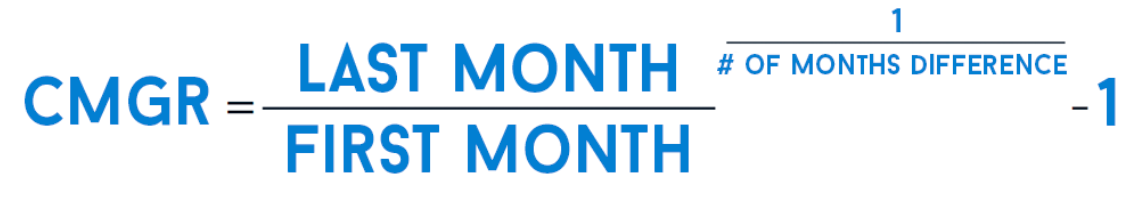

## 분기별 매출 추세

In [18]:
# 분기별 매출 추세는 2024년도 안에서만 비교할 수 없기 때문에
# 2024년 1분기와 지난 3개 연도 (2021, 2022, 2023)의 1분기 매출을 비교함.
temp = df_merged.loc[(df_merged['created_at_x'] >= '2021-01-01') & (~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)

C:\Users\no1\AppData\Local\Temp\ipykernel_22328\1262751989.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



### 1분기 비교

In [19]:
temp1 = temp.groupby(['quarter','year'])['sale_price'].sum().unstack()
temp1

year              2021           2022           2023          2024
quarter                                                           
1        176072.430215  300780.950213  515060.280695  1.048993e+06
2        202876.210194  351642.500250  573737.410643  1.442529e+06
3        244700.000200  399459.580327  688982.300781           NaN
4        268553.070273  456309.830495  842113.230637           NaN

In [20]:
# 연도별 쿼터 매출 평균 구하기
# 2024 제외
col = set(temp1.columns)
col.remove(2024)
col = list(col)

# 3개년 평균 매출
temp1['year_avg'] = temp1[col].T.mean()

In [21]:
len(temp1.columns[:])

5

In [22]:
# 연도별 분기 매출 시각화
fig = px.bar(temp1, barmode='group')

# 색상 설정
colors = ['#B9B5BC'] * len(temp1.columns[:])
colors[-2] = '#95280D'
colors[-1] = '#636EFA' 

# 각 막대의 색상 지정
for i, trace in enumerate(fig.data):
    trace.marker.color = colors[i]

# 레이아웃 설정
fig.update_layout(
    title='연도별 분기당 매출',
    xaxis_title='Quarter',
    yaxis_title='Sale Price',
    legend_title='Year'
)

# 그래프 출력
fig.show()

# 2024년 1분기, 2분기 매출 모두 지난 3개년 평균 매출의 3배 이상을 기록했다.
# 2분기의 경우, 약 20일 가량(6/11 - 6/30)의 데이터가 존재하지 않음에도 높은 수치를 기록했다.

## 시계열 범위 좁히기
### 3월

In [23]:
temp = df_merged.loc[(df_merged['created_at_x'] >= '2024-01-01') & (~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)

C:\Users\no1\AppData\Local\Temp\ipykernel_22328\3445136436.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [24]:
temp1 = temp.loc[temp['week'].isin(range(8,16))]
temp1 = temp1.groupby(['month','week'])['sale_price'].sum()
temp1

month  week
2      8        85022.240091
       9        43620.750036
3      9        34841.180064
       10       85178.780110
       11       89095.680050
       12       96691.830150
       13       92112.060082
4      14       95371.720101
       15      103773.610061
Name: sale_price, dtype: float64

In [25]:
temp1 = temp.loc[temp['week'].isin(range(8,16))]
temp1 = temp1.groupby(['week'])['sale_price'].sum()
px.line(temp1)
# 3월의 주수는 9 - 13이다.
# 주수 9부터 12까지는 매출이 성장하였고, 13에서 약간 감소하였다.
# 그러므로 주수 9 - 12를 상승 요인을 분석하는 주 시계열로 정하고, 13을 부 시계열로 정한다.

### 5월

In [26]:
temp1 = temp.loc[temp['week'].isin(range(14,24))]
temp1 = temp1.groupby(['month','week'])['sale_price'].sum()
temp1

month  week
4      14       95371.720101
       15      103773.610061
       16      102988.240138
       17      109070.620090
       18       32838.140059
5      18       79541.130055
       19      123369.390152
       20      135886.470151
       21      132736.210187
       22      100374.880040
6      22       42715.170045
       23      343696.330226
Name: sale_price, dtype: float64

In [27]:
temp1 = temp.loc[temp['week'].isin(range(14,24))]
temp1 = temp1.groupby(['week'])['sale_price'].sum()
px.line(temp1)
# 5월의 주수는 18 - 22이다.
# 18부터 22까지 21 주차를 제외하면 꾸준히 상승하였다.
# 23 주차에서 폭발적으로 성장했으나, 이는 다른 분석에서 다룰 예정이다.
# 18 - 22를 5월 분석의 시계열 범위로 정한다.

## 3월

### Group by (지역)

#### 주문 별 배송 지역을 구할 수 있는가?

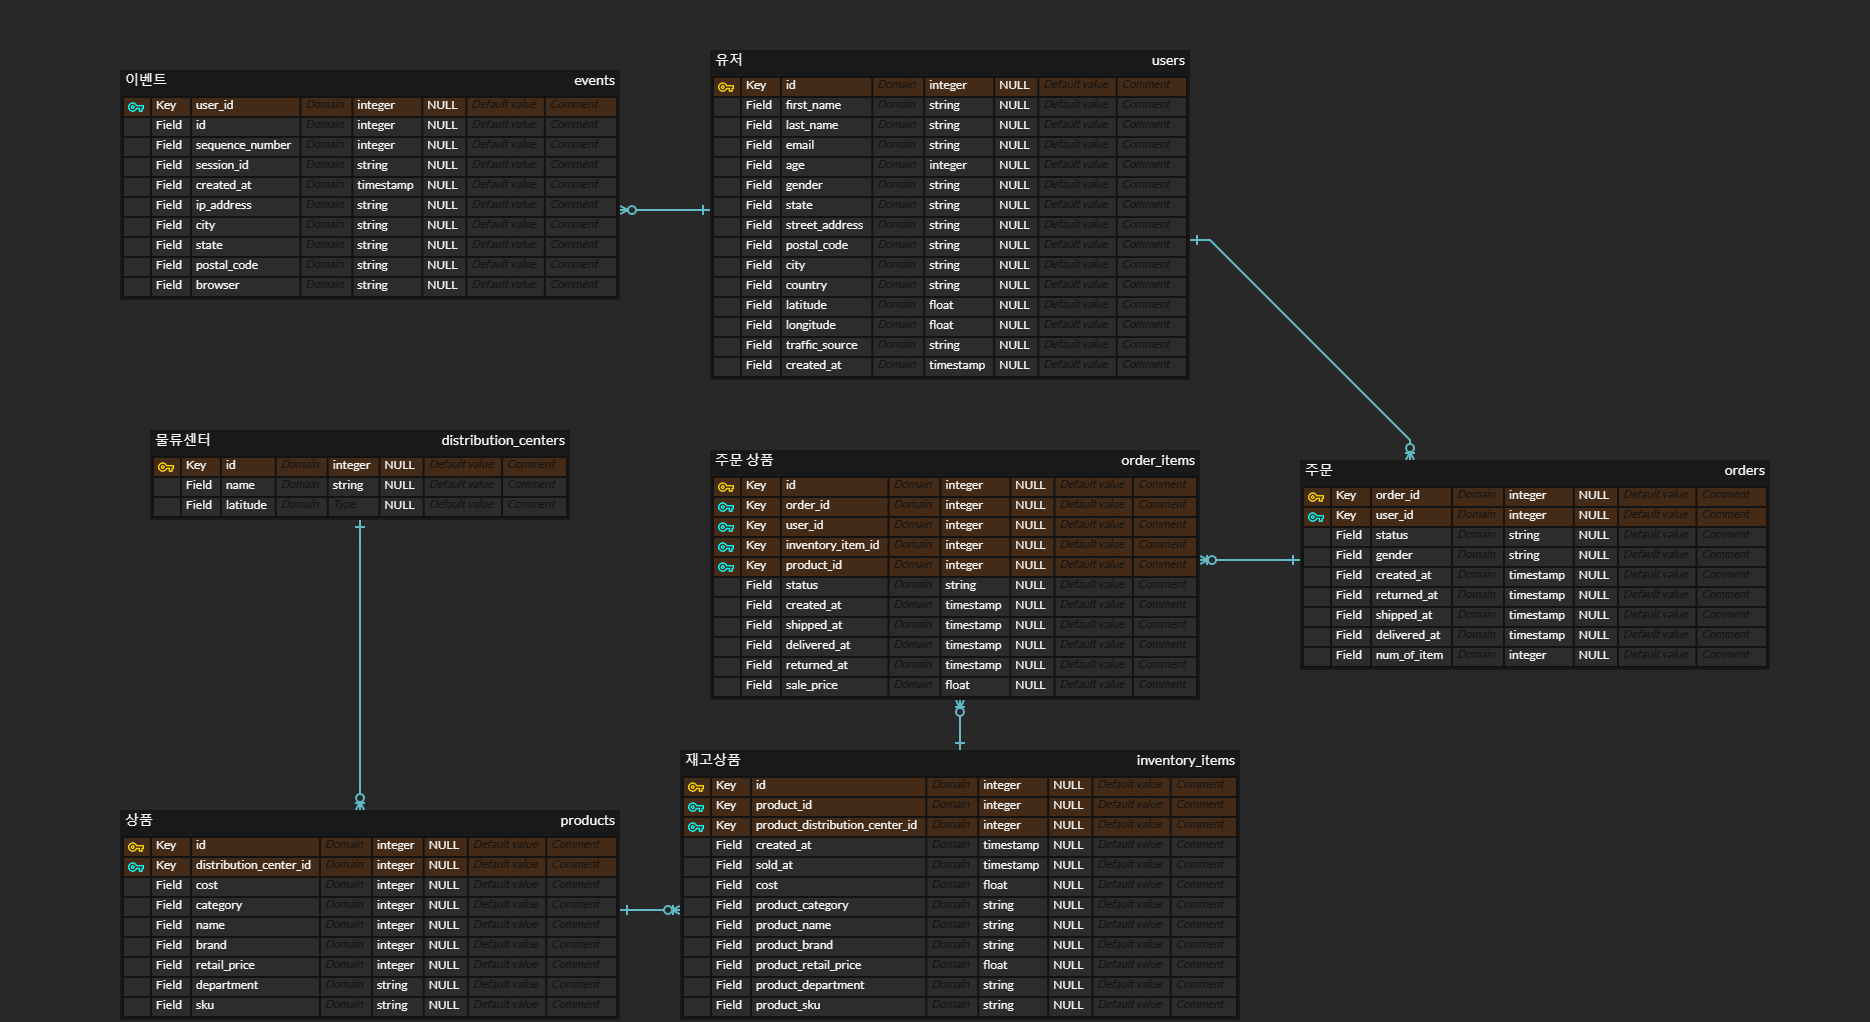
- order, order_item은 주문별 배송 주소를 수집하지 않는다.  
- 다만, 해당 이커머스는 이용자가 회원 가입을 해야 주문할 수 있다.  
- 그러므로 모든 주문은 user_id를 가지며, user_id는 country, state, city를 갖는다.
- 그래서 country, state, city를 이용하여 분석해볼 수 있다.  
- 그러나 실제 배송지 정보는 아니라는 점에서 한계가 있다.

In [28]:
# week 9 - 12
# Group by country 
temp1 = temp.loc[temp['week'].isin(range(9,15))]
sorted(temp1['week'].unique())
# user 불러오기
df_user = pd.read_csv("users.csv", dtype={'id' : 'object'})
# user와 merge하기
temp2 = pd.merge(left = temp1, right = df_user, left_on = 'user_id_x', right_on = 'id')
px.line(temp2.groupby(['week','country'])['sale_price'].sum().unstack())
# 1. China는 국가별 매출 중 가장 많은 매출을 기록했다. 27k ~ 32k.
# 2. United States는 두 번째로 많은 매출을 기록했다. 16k ~ 23k.
# 3. Brasil은 세 번째로 많은 매출을 기록했다. 11k ~ 15k.
# 4. 나머지 국가의 매출은 0.17K ~ 5.6K 사이에 있다.

In [29]:
# 좀 더 시계열을 넓혀보자
# week 9 - 12
temp1 = temp.loc[temp['week'].isin(range(1,16))]
sorted(temp1['week'].unique())
# user 불러오기
df_user = pd.read_csv("users.csv", dtype={'id' : 'object'})
# user와 merge하기
temp2 = pd.merge(left = temp1, right = df_user, left_on = 'user_id_x', right_on = 'id')
px.line(temp2.groupby(['week','country'])['sale_price'].sum().unstack())
# 시계열 week range를 (1, 16)으로 넓혔을 때
# (China, United States, Brasil)이 1, 2, 3위인 경향이 연초부터 지속되었다.
# 셋 모두 등락은 있으나 평균적으로 증가하는 경향을 보인다. 
# 세 국가를 제외한 나머지 국가는 매출이 0 ~ 6K 범위 내에서 유지된다.
# 특정 지역 (China, United States, Brasil)이 다른 지역에 비해 두드러진 매출 상승을 보였다.

In [30]:
# 회귀 추세선을 이용하여 매출 상위 세 국가의 성장률 비교
import statsmodels.api as sm
temp3 = temp2.loc[temp2['country'].isin(['China','United States','Brasil'])].groupby(['week','country'])['sale_price'].sum().unstack()

fig = px.line(temp3)
annotations = []
for country in temp3.columns.unique().values:
    country_df = temp3[country]
    X = sm.add_constant(np.array(country_df.index.astype(int)))
    y = country_df.values
    model = sm.OLS(y, X).fit()
    country_df['trend'] = model.predict(X)
    
    # 추세선 추가
    fig.add_trace(go.Scatter(
        x=country_df.index,
        y=country_df['trend'],
        mode='lines',
        name=f'{country} Trend',
        line=dict(dash='dash')
    ))
    # 회귀 계수 추가
    slope = model.params[1]
    intercept = model.params[0]
    annotations.append(dict(
        x=13,
        y=country_df['trend'][-1],
        xref='x', yref='y',
        text=f'Slope: {slope:.2f}',
        showarrow=True,
        arrowhead=2
    ))

# 레이아웃 설정
fig.update_layout(
    xaxis_title='Week',
    yaxis_title='',
    legend_title='Country',
    xaxis=dict(tickformat='%Y-%W'),
    annotations=annotations
)

# 그래프 출력
fig.show()

# 각 국가의 성장률은 China > United States > Brasil 순이다. (Slope 참고)
# 그러므로 세 국가의 매출 차이는 시간이 지남에 따라 더 벌어질 것이다.

In [31]:
# 지역적 차이가 매출 상승을 설명해주는가?
# 만약에 China, United States, Brasil이 다른 국가에 비해 매출이 상승하여 이로 인해 전체 매출이 증가했다면,
# 전체 매출 내에서 세 국가의 매출 비중이 주수에 따라 점점 상승했을 것이다.
# China, United States, Brasil과 나머지 국가의 매출이 전체 매출에서 얼마나 차지하는지 살펴보자


temp1 = temp.loc[temp['week'].isin(range(1,16))]
sorted(temp1['week'].unique())
# user 불러오기
df_user = pd.read_csv("users.csv", dtype={'id' : 'object'})
# user와 merge하기
temp2 = pd.merge(left = temp1, right = df_user, left_on = 'user_id_x', right_on = 'id')
temp3 = temp2.groupby(['week','country'])['sale_price'].sum().unstack()
col = list(set(temp3.columns) - set(['China','United States','Brasil']))
temp3['other'] = temp3[col].T.sum()
temp3 = temp3[['China','United States','Brasil','other']]
temp3['total'] = temp3.T.sum()
temp4 = temp3.apply(lambda x : x / temp3['total'] * 100)
px.line(temp4[['China','United States','Brasil','other']])

# 전체 매출을 100으로 보았을 때, 각 국가가 이 중 얼마나 차지하는지를 보여주는 시각화이다.
# 세 국가의 비중이 점점 증가하고 있다는 경향을 찾기 어렵다.
# 앞서 살펴본대로, 세 국가의 매출이 점점 증가한 것은 맞으나, 그럼에도 전체 매출 대비 세 국가의 비중이 뚜렷하게 증가한 것은 아니다.
# 그러므로, 해당 기간의 매출 상승은 지역적 차이에서 비롯된 것이 아니다.